# Table of contents
- Hyperparameters:
    + Learning rate
    + Epochs
- Model architecture
    + Architecture
- Transfer learning
- Boosting performance

# I. Tinh chỉnh siêu tham số (hyper-parameters)

## Learning rate
- Khi độ dốc trong gradient giảm thì độ lớn vector gradient cũng giảm, tuy nhiên để hiệu quả hơn, người ta xem xét việc giảm LR tương ứng trong quá trình training: **Scheduling** (giảm theo lịch trình)
 + Khởi tạo: Việc chọn LR thường khó khăn và chủ yếu dựa vào kinh nghiệm và từ các kết quả thực nghiệm.
 + Một số chiến thuật thay đổi LR (learning rate scheduling): warm-up, stepLR, plateau, cosin-annealing...


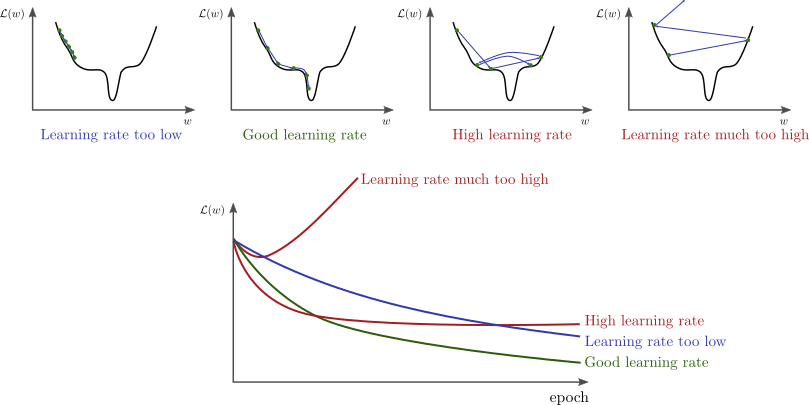

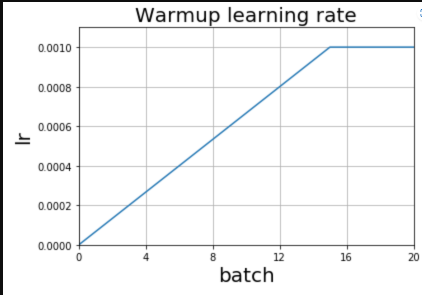

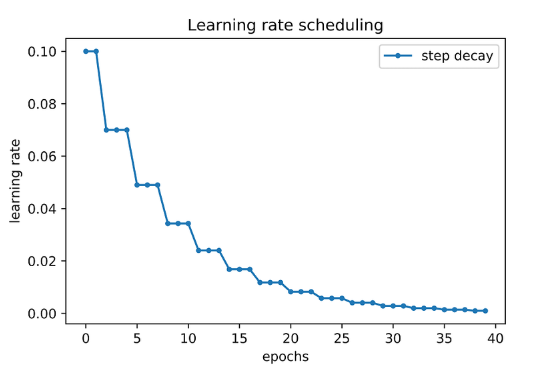

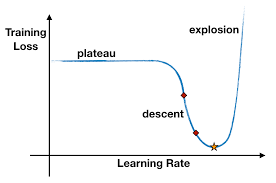

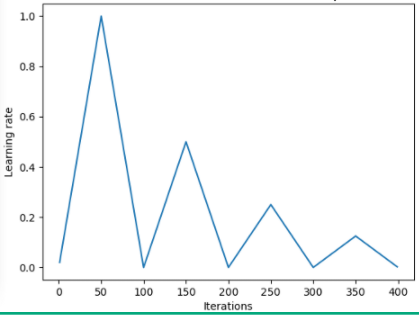

## Epochs
- Số lượng epochs thường được cài đặt cố định
- Khi độ chính xác trên tập val không tăng hoặc giảm một cách liên tục, người ta sẽ dừng huấn luyện.

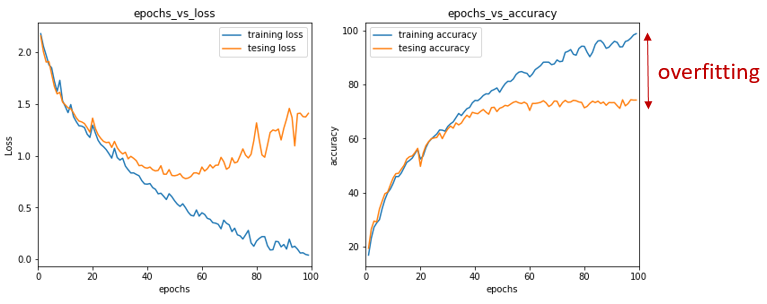

# II. Mô hình
- Độ phức tạp mô hình

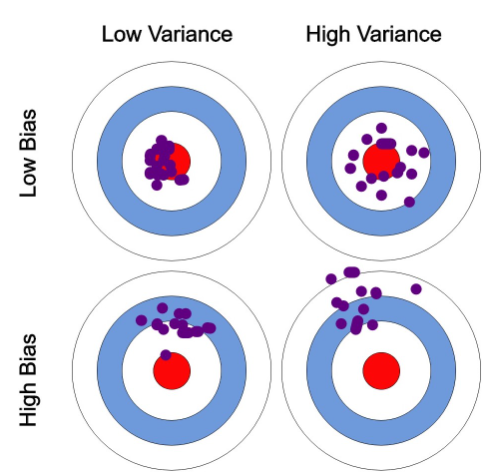

## Transfer learning
  + Thay đổi về kiến trúc: tinh chỉnh, ensemble
  + Thay đổi phương pháp huấn luyện: Freezing layers

## Boosting accuracy
- Thêm dữ liệu
- Tiền xử lý dữ liệu: outlier, missing data,...
- Feature Engineering
- Tuning
- Ensemble
- Cross Validation

# II. Bài tập
- Sử dụng Adult dataset (https://archive.ics.uci.edu/dataset/2/adult)
- Hãy xây dựng 1 mô hình phân loại cơ bản với dữ liệu này (model 1)
- Sử dụng 1 số kỹ thuật tinh chỉnh để tăng cường độ chính xác cho mô hình ở trên (model 1).
   + Nêu rõ đã sử dụng kỹ thuật gì, tại sao lại sử dụng nó.
   + So sánh kết quả mô hình (test output): trước và sau khi sử dụng các kỹ thuật này có gì khác nhau.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models



# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
names = ['age', 'workclass', 'fin_weight', 'education', 'education_num', 'marital_status',
         'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
         'hours_per_week', 'native_country', 'income']
url_test ="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
data = pd.read_csv(url, names=names, na_values=' ?', skipinitialspace=True)
data_test= pd.read_csv(url_test,names=names, na_values=' ?', skipinitialspace=True)
data_test = data_test.drop(0)


In [ ]:
data.head(773737)

,age,workclass,fin_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
data_test.head(87333)

,age,workclass,fin_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fin_weight      32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# Encode categorical features
cat_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
label_encoders = {}
for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])
    data_test[col] = label_encoders[col].fit_transform(data_test[col])

# Normalize numerical features
num_cols = ['age', 'fin_weight', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
data_test[num_cols] = scaler.fit_transform(data_test[num_cols])

# Split data into features and target
X_train = data.drop('income', axis=1)
y_train = data['income']
X_test = data_test.drop('income', axis=1)
y_test = data_test['income']

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
import torch

class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.epochs_no_improve = 0

    def save_checkpoint(self, val_loss, model):
        '''Lưu mô hình khi validation loss giảm.'''
        torch.save(model.state_dict(), 'checkpoint.pt')
        print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model...')




In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.deep_layers = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.deep_layers(x)
        return logits

# Initialize the model
input_size = X_train.shape[1]

num_classes = 2

num_classes = len(label_encoders['income'].classes_)
model_not_finetuned = NeuralNetwork(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_not_finetuned = optim.Adam(model_not_finetuned.parameters(), lr=0.001)

'''

from torch.optim.lr_scheduler import CosineAnnealingLR

# Create a learning rate scheduler
T_max = 10  # Number of epochs for a half cosine annealing cycle
scheduler = CosineAnnealingLR(optimizer, T_max=T_max)


from torch.optim.lr_scheduler import MultiStepLR

# Create a learning rate scheduler
milestones = [5, 10, 15]  # Epochs at which to decay learning rate
gamma = 0.1  # Factor by which to decay learning rate
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

from torch.optim.lr_scheduler import StepLR

# Create a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decay LR by a factor of 0.1 every 5 epochs
'''




'\n\nfrom torch.optim.lr_scheduler import CosineAnnealingLR\n\n# Create a learning rate scheduler\nT_max = 10  # Number of epochs for a half cosine annealing cycle\nscheduler = CosineAnnealingLR(optimizer, T_max=T_max)\n\n\nfrom torch.optim.lr_scheduler import MultiStepLR\n\n# Create a learning rate scheduler\nmilestones = [5, 10, 15]  # Epochs at which to decay learning rate\ngamma = 0.1  # Factor by which to decay learning rate\nscheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)\n\nfrom torch.optim.lr_scheduler import StepLR\n\n# Create a learning rate scheduler\nscheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decay LR by a factor of 0.1 every 5 epochs\n'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau


class NeuralNetworkFine_tune(nn.Module):
    def __init__(self, input_features, num_classes, dropout_rate=0.5):
        super().__init__()
        self.flatten = nn.Flatten()
        self.deep_layers = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Thêm Dropout sau lớp ReLU
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Thêm Dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Thêm Dropout
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Thêm Dropout
            nn.Linear(64, num_classes),
            # Không cần Tanh hoặc LogSoftmax ở đây nếu bạn sử dụng CrossEntropyLoss
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.deep_layers(x)
        return logits

num_classes = 2
# Sử dụng mô hình với Dropout
model_finetuned = NeuralNetworkFine_tune(input_size, num_classes, dropout_rate=0.5)

# Chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xác định loss function và optimizer
criterion = nn.CrossEntropyLoss()
optimizer_finetuned = optim.Adam(model_finetuned.parameters(), lr=0.001)

# Khởi tạo scheduler
scheduler = ReduceLROnPlateau(optimizer_finetuned, 'min', factor=0.1, patience=3, verbose=True)
# Khởi tạo EarlyStopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# Training function
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            tp += ((predicted == labels) & (labels == 1)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

In [ ]:
num_epochs=100
for epoch in range(num_epochs):
    # Huấn luyện và đánh giá với mô hình không được finetune
    train_loss_not_finetuned = train(model_not_finetuned, train_loader, optimizer_not_finetuned, criterion)
    val_loss_not_finetuned, val_accuracy_not_finetuned = validate(model_not_finetuned, val_loader, criterion)
    val_metrics_not_finetuned = evaluate(model_not_finetuned, val_loader)

    # In kết quả
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("Not Finetuned Model - Validation Loss: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(
        val_loss_not_finetuned, val_accuracy_not_finetuned, *val_metrics_not_finetuned))



Epoch 1/100
Not Finetuned Model - Validation Loss: 0.5510, Accuracy: 0.7622, Precision: 0.7622, Recall: 0.0000, F1-score: 0.0000
Epoch 2/100
Not Finetuned Model - Validation Loss: 0.4991, Accuracy: 0.7677, Precision: 0.7677, Recall: 0.9787, F1-score: 0.0238
Epoch 3/100
Not Finetuned Model - Validation Loss: 0.4715, Accuracy: 0.8342, Precision: 0.8342, Recall: 0.7698, F1-score: 0.4318
Epoch 4/100
Not Finetuned Model - Validation Loss: 0.4674, Accuracy: 0.8399, Precision: 0.8399, Recall: 0.7635, F1-score: 0.4737
Epoch 5/100
Not Finetuned Model - Validation Loss: 0.4665, Accuracy: 0.8388, Precision: 0.8388, Recall: 0.7811, F1-score: 0.4478
Epoch 6/100
Not Finetuned Model - Validation Loss: 0.4669, Accuracy: 0.8402, Precision: 0.8402, Recall: 0.7905, F1-score: 0.4463
Epoch 7/100
Not Finetuned Model - Validation Loss: 0.4638, Accuracy: 0.8431, Precision: 0.8431, Recall: 0.7533, F1-score: 0.5062
Epoch 8/100
Not Finetuned Model - Validation Loss: 0.4649, Accuracy: 0.8407, Precision: 0.8407, R

In [ ]:
num_epochs=100
for epoch in range(num_epochs):
    # Huấn luyện và đánh giá với mô hình được finetune
    train_loss_finetuned = train(model_finetuned, train_loader, optimizer_finetuned, criterion)
    val_loss_finetuned, val_accuracy_finetuned = validate(model_finetuned, val_loader, criterion)
    val_metrics_finetuned = evaluate(model_finetuned, val_loader)

    # In kết quả
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("Finetuned Model - Validation Loss: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(
        val_loss_finetuned, val_accuracy_finetuned, *val_metrics_finetuned))
        # Gọi EarlyStopping
    early_stopping(val_loss_finetuned, model_finetuned)
    scheduler.step(val_loss_finetuned)

    if early_stopping.early_stop:
        print("Early stopping")
        break
# Load lại bản sao tốt nhất của mô hình
model_finetuned.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1/100
Finetuned Model - Validation Loss: 0.4734, Accuracy: 0.7656, Precision: 0.7656, Recall: 0.5056, F1-score: 0.6539
Validation loss decreased (-0.473357 --> 0.473357).  Saving model...
Epoch 2/100
Finetuned Model - Validation Loss: 0.4116, Accuracy: 0.8213, Precision: 0.8213, Recall: 0.6714, F1-score: 0.4866
Validation loss decreased (-0.411641 --> 0.411641).  Saving model...
Epoch 3/100
Finetuned Model - Validation Loss: 0.3764, Accuracy: 0.8281, Precision: 0.8281, Recall: 0.7475, F1-score: 0.4189
Validation loss decreased (-0.376423 --> 0.376423).  Saving model...
Epoch 4/100
Finetuned Model - Validation Loss: 0.3566, Accuracy: 0.8369, Precision: 0.8369, Recall: 0.7428, F1-score: 0.4804
Validation loss decreased (-0.356551 --> 0.356551).  Saving model...
Epoch 5/100
Finetuned Model - Validation Loss: 0.3504, Accuracy: 0.8350, Precision: 0.8350, Recall: 0.8185, F1-score: 0.3936
Validation loss decreased (-0.350377 --> 0.350377).  Saving model...
Epoch 6/100
Finetuned Model - 

<All keys matched successfully>

In [ ]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Evaluate on test set in mode not finetune
val_accuracy, val_precision, val_recall, val_f1_score = evaluate(model_not_finetuned, val_loader)
print(f"Validation Metrics: Accuracy={val_accuracy:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1-score={val_f1_score:.4f}")
test_accuracy, test_precision, test_recall, test_f1_score = evaluate(model_not_finetuned, test_loader)
print(f"Test Metrics: Accuracy={test_accuracy:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1-score={test_f1_score:.4f}")

# Evaluate on test set in mode finetune
val_accuracy, val_precision, val_recall, val_f1_score = evaluate(model_finetuned, val_loader)
print(f"Validation Metrics Model Finetuned: Accuracy={val_accuracy:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1-score={val_f1_score:.4f}")

# Evaluate on test set
test_accuracy, test_precision, test_recall, test_f1_score = evaluate(model_finetuned, test_loader)
print(f"Test Metrics Model Finetuned : Accuracy={test_accuracy:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1-score={test_f1_score:.4f}")

Validation Metrics: Accuracy=0.8555, Precision=0.7643, Recall=0.5677, F1-score=0.6515
Test Metrics: Accuracy=0.8492, Precision=0.7415, Recall=0.5482, F1-score=0.6303
Validation Metrics Model Finetuned: Accuracy=0.8557, Precision=0.7441, Recall=0.5992, F1-score=0.6638
Test Metrics Model Finetuned : Accuracy=0.8467, Precision=0.7144, Recall=0.5775, F1-score=0.6387


# Trình bày lí do


Trong bài em đã sử dụng các kỹ thuật kỹ thuật như:

+ Learning schedule: Plateau: Nếu như Loss không giảm thì giảm learning rate để nó có thể vào được global minimum.

Regularization:
+ Dropout: Giúp cho mô hình k học phụ thuộc vào bất kỳ layer nào cả, tổng quát hóa tốt và nó cũng đc coi là bắt chước essemble nhưng với tính toán ít chi phí hơn.
+ StoppingEarly: Dừng nếu như mô hình không thể tiếp tục cải thiện hiệu suất để tránh lãng phí tài nguyên vô nghĩa.

Ngoài ra em cũng thay đổi 1 số cấu trúc mạng:
+ Sử dụng mạng sâu hơn để nó có thể biểu diễn phức tạp hơn (trong trường hợp này k giúp đc gì nhiều).
+ Sử dụng lớp cuối cùng là linear thay vì sigmoid hay tanh vì đầu ra đã là logit, nếu thêm tanh hoặc sigmoid vào cuối nó còn có thể làm sai lầm đến tính toán trong CrossentropyLoss.


# So sánh kết quả


Validation Metrics: Accuracy=0.8555, Precision=0.7643, Recall=0.5677, F1-score=0.6515

Test Metrics: Accuracy=0.8492, Precision=0.7415, Recall=0.5482, F1-score=0.6303

Validation Metrics Model Finetuned: Accuracy=0.8557, Precision=0.7441, Recall=0.5992, F1-score=0.6638

Test Metrics Model Finetuned : Accuracy=0.8467, Precision=0.7144, Recall=0.5775, F1-score=0.6387

Kết Luận:
==
Cho thấy trước và sau khi Finetune đều không có quá nhiều khác biệt về hiệu suất.


Cho thấy là cả 2 mô hình trước và sau khi Finetune đều không bị overfitting và với accuracy ~ 85% cho thấy hiệu suất mô hình khá tốt khi phân loại trên dữ liệu Adult.


Nhưng
==
Nếu không fine tune thì mô hình sẽ mất nhiều tài nguyên tính toán hơn khi train mô hình.

===> Vì vậy em đánh giá Mô hình sau khi Fine tune sẽ giúp chúng ta tiết kiệm được thời gian và sức mạnh tính toán nhưng vẫn giữ được hiệu suất mô hình khá tốt.